In [43]:
!pip install vaderSentiment
!pip install -U textblob

     |████████████████████████████████| 636 kB 4.7 MB/s eta 0:00:01


In [110]:
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from textblob import TextBlob
from tqdm import tqdm
import pandas as pd
import numpy as np
import regex as re
import unicodedata
import json
import seaborn as sns
sns.set_style('white')

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.tokenize import TweetTokenizer

In [153]:
df = pd.read_csv('../data/tweets_01-08-2021.csv')
df

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
0,98454970654916608,Republicans and Democrats have both created ou...,f,f,TweetDeck,49,255,2011-08-02 18:07:48,f
1,1234653427789070336,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03 01:34:50,f
2,1218010753434820614,RT @CBS_Herridge: READ: Letter to surveillance...,t,f,Twitter for iPhone,0,7396,2020-01-17 03:22:47,f
3,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,2020-09-12 20:10:58,f
4,1218159531554897920,RT @MZHemingway: Very friendly telling of even...,t,f,Twitter for iPhone,0,9081,2020-01-17 13:13:59,f
...,...,...,...,...,...,...,...,...,...
56566,1319485303363571714,RT @RandPaul: I don’t know why @JoeBiden think...,t,f,Twitter for iPhone,0,20683,2020-10-23 03:46:25,f
56567,1319484210101379072,RT @EliseStefanik: President @realDonaldTrump ...,t,f,Twitter for iPhone,0,9869,2020-10-23 03:42:05,f
56568,1319444420861829121,RT @TeamTrump: LIVE: Presidential Debate #Deba...,t,f,Twitter for iPhone,0,8197,2020-10-23 01:03:58,f
56569,1319384118849949702,Just signed an order to support the workers of...,f,f,Twitter for iPhone,176289,36001,2020-10-22 21:04:21,f


# Sentiment Analysis

## Pre-processing the data

Source: https://link-springer-com.ezproxy.cul.columbia.edu/content/pdf/10.1007%2F978-3-319-09339-0.pdf (page 617)

In [154]:
# Add additional feature 'retweeted'
tweets = df['text'].to_list()
values = []

for tweet in tweets:
    if tweet.startswith('RT'):
        value = True
    else:
        value = False

    values.append(value)
    
df['retweeted'] = values

In [166]:
# Step 1: Denoising – Remove Username, Hashtags, Links, Change to lowercase
def denoise(tweets):
    
    clean_tweets = []

    for tweet in tweets:
        result = unicodedata.normalize('NFKD', tweet)
        result = re.sub("@(\w{1,15})", " ", result) # mentions
        result = re.sub("#(\w{1,15})", " ", result) # hashtags
        result = re.sub("https?://([^\s]+)", ' ', result) # links
        result = re.sub("RT", ' ', result) # RT : 
        
        result = re.sub(" &amp", ' ', result) # &amp
        result = re.sub("[\n\r\t\0]", ' ', result) # new line, tabs, etc
        
        result = re.sub(r"\'t", "not", result)
        result = re.sub(r"\'re", " are", result)
        result = re.sub(r"\'s", " is", result)
        result = re.sub(r"\'d", " would", result)
        result = re.sub(r"\'ll", " will", result)
        result = re.sub(r"\'ve", " have", result)
        result = re.sub(r"\'m", " am", result)
        
        result = re.sub(r'\b\w\b', ' ', result) # sigle letter
        result = re.sub('[!,.-;:\+\-\"“”\[\]{}]', ' ', result) # punct
        
        result = re.sub('\s{2,}', ' ', result) # 2+ whitespaces

        result = result.strip().lower()
                
        clean_tweets.append(result)
        
    return clean_tweets

In [167]:
# Step 2: Normalizing contractions
# source: https://towardsdatascience.com/text-normalization-7ecc8e084e31

def normalize_contractions(tweets):
    contraction_list = json.loads(open('../data/english_contractions.json', 'r').read())
    clean_tweets = []
    
    for tweet in tweets:
        clean_tweets.append(_normalize_contractions_text(tweet, contraction_list))
        
    return clean_tweets

def _normalize_contractions_text(text, contractions):
    """
    This function normalizes english contractions.
    """
    new_token_list = []
    token_list = text.split()
    
    for word_pos in range(len(token_list)):
        word = token_list[word_pos]
        first_upper = False
        if word[0].isupper():
            first_upper = True
        if word.lower() in contractions:
            replacement = contractions[word.lower()]
            if first_upper:
                replacement = replacement[0].upper()+replacement[1:]
            replacement_tokens = replacement.split()
            if len(replacement_tokens)>1:
                new_token_list.append(replacement_tokens[0])
                new_token_list.append(replacement_tokens[1])
            else:
                new_token_list.append(replacement_tokens[0])
        else:
            new_token_list.append(word)
    
    tweet = " ".join(new_token_list).strip(" ")
    
    return tweet

In [177]:
def remove_stop_words(tweets):
    stopwords_english = stopwords.words('english')
    
    to_be_removed = ["haven't", "against", "not", "weren't", "won't", 'no']
    
    for word in to_be_removed:
        stopwords_english.remove(word)
        
    stopwords_english.append('pm')
    stopwords_english.append('am')

    clean_tweets = []
    
    # instantiate the tokenizer class
    tokenizer = TweetTokenizer(preserve_case=False, 
                           strip_handles=True,
                           reduce_len=True)
    
    for tweet in tweets:
        
        # tokenize the tweets
        tweet_tokens = tokenizer.tokenize(tweet)
        
        tweet_clean = ''
        
        for word in tweet_tokens: # Go through every word in your tokens list
            if word not in stopwords_english:
                tweet_clean = tweet_clean + ' ' + word
                
        clean_tweets.append(tweet_clean.strip())
        
    return clean_tweets

In [174]:
def deEmojify(tweets):
    clean_tweets = []
    
    for tweet in tweets:
        regrex_pattern = re.compile(pattern = "["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags = re.UNICODE)
        
        clean_tweets.append(regrex_pattern.sub(r'', tweet))    
        
    return clean_tweets

In [175]:
def normalization_pipeline(tweets):

    tweets = denoise(tweets)
    tweets = deEmojify(tweets)
    tweets = normalize_contractions(tweets)
    tweets = remove_stop_words(tweets)

    return tweets

In [178]:
# load tweets
tweets = df['text'].to_list()

clean_tweets = normalization_pipeline(tweets)

In [180]:
df['sentiment_text'] = clean_tweets

## Sentiment Analysis

In [181]:
def sentiment_scores(tweet):
  
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
    
    sentiment_score = sid_obj.polarity_scores(tweet)['compound'] 
    blob_dict = TextBlob(tweet).sentiment
    
    sentiment_vader.append(sentiment_score)
    polarity.append(blob_dict.polarity)
    subjectivity.append(blob_dict.subjectivity)

In [182]:
# compute scores
tweets_clean = df['sentiment_text']

polarity = []
subjectivity = []
sentiment_vader = []

for tweet in tweets_clean:
    sentiment_scores(tweet)
    
df['subjectivity_score'] = subjectivity
df['polarity'] = polarity
df['sentiment_vader'] = sentiment_vader

## Plotting the results

In [183]:
def get_rid_of_spine(axes):
    for ax in axes:
        for spine in ax.spines.values():
            spine.set_visible(False)

Text(0.5, 1.03, 'The distribution of sentiment scores')

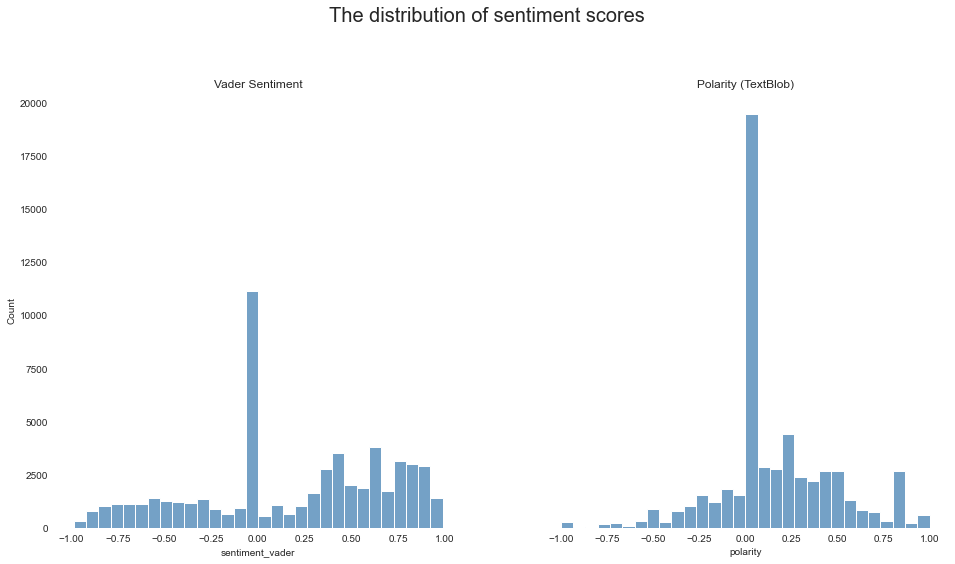

In [184]:
# Plotting polarity vs sentiment
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8), sharey=True)
g1 = sns.histplot(x=df['sentiment_vader'], color="steelblue", ax=ax1, bins = 30)
g2 = sns.histplot(x=df['polarity'], color="steelblue", ax=ax2, bins = 30)

ax1.set_title("Vader Sentiment")
ax2.set_title("Polarity (TextBlob)")

get_rid_of_spine([ax1, ax2])
plt.suptitle("The distribution of sentiment scores", y = 1.03, fontsize=20)

Text(0.5, 1.03, 'The distribution of subjectivity score')

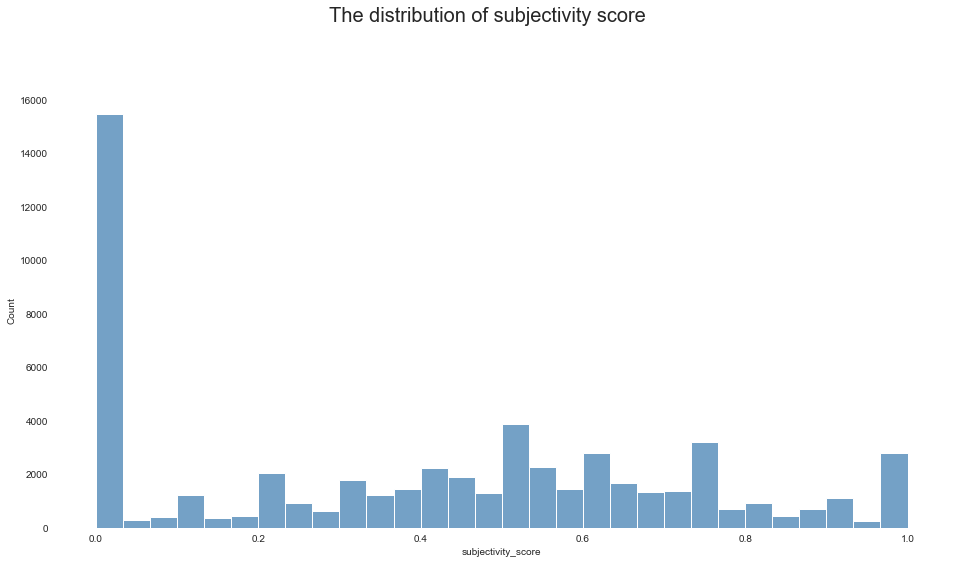

In [185]:
# Plotting objectivity
# subjectivity_score = 0: very objective
# subjectivity_score = 1: very subjective
fig, ax = plt.subplots(figsize=(16,8))
g1 = sns.histplot(x=df['subjectivity_score'], color="steelblue", bins = 30)
get_rid_of_spine([ax])
plt.suptitle("The distribution of subjectivity score", y = 1.03, fontsize=20)

In [186]:
df.to_csv(r'../output/sentiment_analysis_clean.csv', index = False)